# Generazione di dati sintetici dei sensori dell'applicazione di Generocity
Lo scopo dei sensori dell'applicazione è rilevare se l'utente è in automobile oppure no in in determinato timestamp.
I dati sintetici sono prodotti da sondaggi somministrati a utenti che utilizzano regolarmente la propria auto per svolgere attività o andare a lavorare.
Quindi i dati estratti dagli utenti vengono utilizzati in maniera anonima per produrre inizialmente una profilazione verosimile dei viaggi che farebbero quegli utenti in una settimana.
Lo stato dell'utente al momento della formazione degli spostamenti verosimili può essere assegnato a:

*   Walk (L'utente sta camminando)
*   Automotive (L'utente sta guidando)
*   Public (L'utente si trova sui mezzi publici)
*   Home (L'utente si trova a casa)
*   Act (L'utente sta svolgendo una attività)
*   Work (L'utente si trova a lavoro)

In base allo stato dell'utente in un determinato momento e alle abitudini di utilizzo della tecnologia espresse nel sondaggio, si identificano i valori dei sensori in un determinato istante.







In [11]:
import pandas as pd
import csv
import re
import random
from datetime import datetime, timedelta

In [12]:
days = ['lunedi', 'martedi', 'mercoledi', 'giovedi', 'venerdi', 'sabato', 'domenica']

# Raccoglimento delle risposte aperte sulle ulteriori attività regolari svolte con la propria automobile

L'utente in questa sezione potrebbe rispondere con qualsiasi formato per esprimere lo spostamento, perciò vengono utilizzate varie Regex per catturare pattern di parole ed estrapolare infine i giorni e gli orari in cui vi è uno spostamento in auto all'interno della settimana dell'utente.
I pattern catturati sono principalmente i seguenti:

*   Giorno specifico (ex. Domenica alle 19)
*   Giorni generici (ex. 3 volte a settimana per le 17)
*   Tutti i giorni (ex. ogni giorno alle 20)

Inoltre vengono catturate espressioni come circa/quasi che introducono variabilità di minuti nell'intorno dell'orario specificato oppure variabilità di numero di giorni generici.

Inoltre di default viene introdotto un rumore per l'orario di partenza per l'attività poichè è raro che l'utente specifichi un orario e sia sempre perfettamente puntale al minuto.  





In [13]:
def normalize_text(t):
    """ Normalizza il testo """
    t = t.lower()
    t = t.replace('..', '.')
    t = re.sub(r'[è|é]', 'e', t)
    t = re.sub(r'[à|á]', 'a', t)
    t = re.sub(r'[ì|í]', 'i', t)
    t = re.sub(r'[ò|ó]', 'o', t)
    t = re.sub(r'[ù|ú]', 'u', t)
    t = re.sub(r'domeniche', 'domenica', t)
    t = re.sub(r'sabati', 'sabato', t)
    t = re.sub(r'volta', 'volte', t)
    t = re.sub(r'\s+', ' ', t).strip()
    t = t.replace('. ', ' ')
    t = t.replace(',', '')
    t = t.replace(';', '')
    t = t.replace('\n', '')
    return t


def text_to_number(text):
    """ Converte i numeri scritti in lettere nei loro equivalenti numerici """
    numbers = {
        "una": 1, "uno": 1, "due": 2, "tre": 3, "quattro": 4, "cinque": 5,
        "sei": 6, "sette": 7, "otto": 8, "nove": 9, "dieci": 10
    }
    return numbers.get(text, text)


def normalize_time(time_str):
    """ Converte gli orari in formato HH:MM. """
    if ':' not in time_str and '.' not in time_str:
        time_str += '.00'
    time_str = time_str.replace(':', '.')
    hour, minute = map(int, time_str.split('.'))
    return f"{hour:02}.{minute:02}"


def random_interval_activity(time, n1, n2):
    """ Restituisce l'orario cambiandolo di [-range, +range] minuti utilizzando una gaussiana """
    # calcolo dell'intorno in maniera randomica
    time_normalized = normalize_time(time)
    start_time_obj, time_start = dirty_time(time_normalized, n1, n2)

    average = 20  # media settata a 20 minuti
    sigma = 5  # Deviazione standard
    rand = random.gauss(average, sigma)
    # calcolo della fine del trip in maniera randomica
    end_time_obj = start_time_obj + timedelta(minutes=rand)
    time_end = end_time_obj.strftime("%H.%M")

    return time_start, time_end


def generic_day_assignment(matches, flag, day_time):
    """ Genera i trip in macchina per le attività con il pattern n giorni alle ...  """
    prob = 90
    for match in matches:
        if flag == "all":
            times = 7
            almost_all = match[0]
            time_str = match[3]
            about = match[4]
            for _ in range(7):
                if almost_all:
                    rand = random.randint(0, 100)
                    if rand >= prob:
                        times = times - 1
        else:
            times = int(text_to_number(match[0]))
            time_str = match[3]
            about = match[4]

        normalized_time = normalize_time(time_str)
        prob = 90
        total_slots = times
        returned = random_interval_activity(normalized_time, n1=30,
                                            n2=180)  # Attività settata tra mezz'ora e 3 ore. Media:2 ore
        while total_slots > 0:
            for day in random.sample(days, min(total_slots, len(days))):  # 8 volte -> 7 volte
                if about:
                    time_ab = random_interval_activity(normalized_time, n1=-20, n2=20)
                else:
                    time_ab = random_interval_activity(normalized_time, n1=-10, n2=10)
                return_about = random_interval_activity(returned[0], n1=-10, n2=10)
                day_time["automotive"][day].append(time_ab + return_about + ("act",))
                total_slots -= 1
    return day_time


def specific_day_assignment(matches, day_time, t, pattern_time):
    """ Genera i trip in macchina per le attività con il pattern 'giorno specifico' alle ...  """
    for i in range(len(matches)):
        match = matches[i]
        almost_all = match[0]
        if almost_all:
            prob = 80
        else:
            prob = 100
        rand = random.randint(0, 100)
        if rand <= prob:
            day = match[1]
            text_after_day = t[t.index(day) + len(day):]
            expression_time = re.findall(pattern_time, text_after_day)
            if expression_time:
                time_str = expression_time[0][1]
                normalized_time = normalize_time(time_str)
                about = expression_time[0][2]
                if about:
                    normalized_time = random_interval_activity(normalized_time, n1=-20, n2=20)
                else:
                    normalized_time = random_interval_activity(normalized_time, n1=-10, n2=10)
                returning = random_interval_activity(normalized_time[1], n1=30, n2=180)

                day_time["automotive"][day].append((normalized_time + returning + (
                "act",)))  # aggiunta del ritorno dall'attività con una durata media di 2 ore, tra 3 minuti e 3 ore

    return day_time


def extract_auto_activities(t):
    """ Cattura i principali pattern e attribuisce gli orari ai giorni """
    t = normalize_text(t)

    # pattern n volte a settimana alle time
    pattern_n_times_week = (r"(\d+|una|uno|due|tre|quattro|cinque|sei|sette|otto|nove|dieci)\s*(volte|giorni)\s*.*?\s*"
                            r"(alle|per le|a|dalle)\s*(\d{1,2}(?:[:.]\d{0,2})?)\s*(circa)*\s*")

    # pattern giorno_settimana alle time
    pattern_specific_day = (r"(piu o meno |quasi tutti i |quasi tutte le |quasi ogni |quasi tutti i )*"
                            r"(lunedi|martedi|mercoledi|giovedi|venerdi|sabato|domenica)")
    pattern_specific_time = r"(alle|per le|a|dalle|le)*\s*(\d{1,2}(?:[:.]\d{0,2})?)\s*(circa)*"

    # pattern tutti i giorni alle
    pattern_all_days = \
        (r"(piu o meno |quasi )*"
         r"(tutti i giorni|ogni giorno|tutta la |tutte le mattine|tutte le sere|ogni mattina|ogni sera|sempre)"
         r"\s*.*?\s*(alle|per le|a|dalle)\s*(\d{1,2}(?:[:.]\d{0,2})?)\s*(circa)*\s*")

    # definizione dei trip a piedi, in macchina o con mezzi di trasporto
    day_time_dict = {"walking": {day: [] for day in days}, "automotive": {day: [] for day in days},
                     "public": {day: [] for day in days}}

    matches = re.findall(pattern_n_times_week, t)
    generic_day_assignment(matches, "num", day_time_dict)

    matches = re.findall(pattern_all_days, t)
    generic_day_assignment(matches, "all", day_time_dict)

    matches = re.findall(pattern_specific_day, t)
    specific_day_assignment(matches, day_time_dict, t, pattern_specific_time)
    return day_time_dict

## Estrazione dei dati forniti dai sondaggi

In questa sezione vengono estrapolate le informazioni fornite dall'utente tramite i sondaggi. Queste informazioni vengono utilizzate per costruire tutti gli spostamenti e gli stati dell'utente all'interno di una settimana.

In ordine vengono effettuati i seguenti passaggi:


*   Estrazione delle informazioni dal csv e regolarizzare i valori
*   Vengono assegnati gli intervalli automotive per quando l'utente va in macchina a lavoro o alle attività
*   Vengono assegnati gli intervalli work in cui l'utente lavora
*   vengono gestite le collisioni tra i vari intervalli e splittati gli intervalli che sono a cavallo di due giorni
*   Vengono assegnati gli intervalli walk in cui l'utente cammina per andare a lavoro se è vicino oppure per andare a prendere l'auto o aspettare il mezzo pubblico
*   Vengono assegnati gli intervalli home in cui l'utente è a casa

Ogni orario viene sporcato da una randomicità per rendere la simulazione più verosimile.



In [14]:


def extract_user_habits(dataframe):
    """ Estrae le abitudini degli utenti dalle risposte del questionario """
    habits = []
    for i, row in dataframe.iterrows():
        user_habits = {}
        user_habits['index'] = i
        user_habits['os_phone'] = row.iloc[4]  # Android o iphone
        user_habits['bluetooth'] = row.iloc[5] == 'Si'  # usi bluetooth?
        user_habits['bluetooth_frequency'] = row.iloc[6]  # quanto spesso?
        user_habits['bluetooth_last_time'] = row.iloc[7] if not pd.isna(row.iloc[7]) else "Non ricordo"  # ultima volta?
        user_habits['bluetooth_connection'] = row.iloc[8] if not pd.isna(
            row.iloc[8]) else "Dipende"  # si connette manuale o automatica?
        user_habits['bluetooth_other'] = row.iloc[9] if not pd.isna(
            row.iloc[9]) else "Mai"  # ogni quanto ti connetti al bluetooth di altre macchine?
        user_habits['carplay'] = row.iloc[10] == 'Si'  # ha il carplay?
        user_habits['carplay_frequency'] = row.iloc[11] if user_habits[
            'carplay'] else "Mai"  # ogni quanto ti connetti ad esso?
        user_habits['carplay_connection'] = row.iloc[12] if user_habits[
            'carplay'] else "Nessuno dei due"  # con cavo o wireless?
        user_habits['carplay_other'] = row.iloc[13] if not pd.isna(
            row.iloc[13]) else "Mai"  # ogni quanto ti connetti al carplay di altre auto?
        user_habits['charging_frequency'] = row.iloc[14] if not pd.isna(
            row.iloc[14]) else "Mai"  # ogni quanto carichi il telefono in auto?
        user_habits['charging_place'] = row.iloc[15] if not pd.isna(
            row.iloc[15]) else "Non lo collego"  # lo attacchi all'accendisigari o all'auto?
        user_habits['wifi_home'] = row.iloc[16] == 'Si'  # hai un wifi in casa che usi?
        user_habits['wifi_work_frequency'] = row.iloc[17] if not pd.isna(
            row.iloc[17]) or row.iloc[17] == 'No' else "Mai"  # quanto spesso ti connetti al wifi al lavoro?
        user_habits['commute'] = {
            'driving_to_work_frequency': row.iloc[18] if not pd.isna(row.iloc[18]) else "Mai",
            # quanto spesso vai in macchina a lavoro?
            'distance': row.iloc[19] if not pd.isna(row.iloc[19]) else "3.0",  # distanza casa-lavoro in km
            'duration': row.iloc[20] if not pd.isna(row.iloc[20]) or row.iloc[20] == "No" else "0.15.00",  # distanza casa-lavoro in minuti
            'days_per_week': row.iloc[21] if not pd.isna(row.iloc[21]) else 3.0,
            # quanti giorni a settimana vai a lavoro
            'leave_home': row.iloc[22] if not pd.isna(row.iloc[22]) or row.iloc[22] == "No" else "8:00:00",
            # a che ora lasci casa per andare a lavoro
            'leave_work': row.iloc[23] if not pd.isna(row.iloc[23]) or row.iloc[23] == "No" else "17:10:00",
            # a che ora lasci il lavoro per tornare a casa
        }
        user_habits['activities_exist'] = row.iloc[24] == "Si"  # fai attività regolari andandoci in macchina?
        user_habits['activities'] = row.iloc[25] if not pd.isna(row.iloc[25]) else ""  # Stringa con le attività
        #user_habits['sex'] = row.iloc[26] if not pd.isna(row.iloc[26]) else random.randint(0, 1)  # Sesso dell'utente
        #user_habits['age'] = row.iloc[27] if not pd.isna(row.iloc[27]) else random.randint(18, 50)  # Età dell'utente
        prepare_data(user_habits)
        habits.append(user_habits)
    return habits


def dirty_time(time, n1, n2):
    """ Aggiunge un rumore casuale al timestamp dato da limiti """
    rand = random.randint(n1, n2)

    time_obj = datetime.strptime(time, "%H.%M")
    start_time_obj = time_obj + timedelta(minutes=rand)
    time = start_time_obj.strftime("%H.%M")
    return start_time_obj, time


def extract_working_trips(commute, trips):
    """ Genera i trip per andare a lavoro in macchina altrimenti con i mezzi o a piedi """
    working_days = ['lunedi', 'martedi', 'mercoledi', 'giovedi', 'venerdi', 'sabato']

    morning = commute['leave_home']
    duration = datetime.strptime(commute['duration'], "%H.%M")
    duration = duration.hour * 60 + duration.minute
    distance = commute['distance']
    returning = commute['leave_work']
    variation = int(duration / 100 * 30)

    for day in random.sample(working_days, int(commute['days_per_week'])):

        rand = random.randint(0, 100)
        if rand < commute['driving_to_work_frequency'] * 100:
            # va in macchina
            dirty_duration_morning = random.randint(-variation, variation) + duration  # più o meno del 20%
            obj_morning, dirty_morning = dirty_time(morning, -5,
                                                    15)  # qui è compreso il viaggio da fare fino alla macchina
            end_morning = obj_morning + timedelta(minutes=dirty_duration_morning)
            end_morning = end_morning.strftime("%H.%M")

            dirty_duration_returning = random.randint(-variation, variation) + duration  # più o meno del 20%
            obj_returning, dirty_returning = dirty_time(returning, -5,
                                                        15)  # qui è compreso il viaggio da fare fino alla macchina
            end_returning = obj_returning + timedelta(minutes=dirty_duration_returning)
            end_returning = end_returning.strftime("%H.%M")

            trips['automotive'][day].append((dirty_morning, end_morning, dirty_returning, end_returning, "work"))
            pass
        else:
            if distance < 1:
                obj_morning, dirty_morning = dirty_time(morning, -10, 10)
                end_morning = obj_morning + timedelta(minutes=random.randint(5, 10))
                end_morning = end_morning.strftime("%H.%M")

                obj_returning, dirty_returning = dirty_time(returning, -10, 10)
                end_returning = obj_returning + timedelta(minutes=random.randint(5, 10))
                end_returning = end_returning.strftime("%H.%M")
                trips['walking'][day].append(
                    (dirty_morning, end_morning, dirty_returning, end_returning, "walking_to_work"))
            else:

                dirty_duration_morning = random.randint(-variation, variation) + duration  # più o meno del 20%
                obj_morning, dirty_morning = dirty_time(morning, 5,
                                                        25)  # qui è compreso il viaggio da fare fino alla fermata + aspettare il bus
                end_morning = obj_morning + timedelta(minutes=dirty_duration_morning)
                end_morning = end_morning.strftime("%H.%M")

                dirty_duration_returning = random.randint(-variation, variation) + duration  # più o meno del 20%
                obj_returning, dirty_returning = dirty_time(returning, 5,
                                                            25)  # qui è compreso il viaggio da fare fino alla fermata + aspettare il bus
                end_returning = obj_returning + timedelta(minutes=dirty_duration_returning)
                end_returning = end_returning.strftime("%H.%M")

                trips['public'][day].append((dirty_morning, end_morning, dirty_returning, end_returning, "work"))
    return trips


def sort_trips(trips):
    """ Ordina i trip in base alla data di inizio """
    for mode in trips:
        for day in trips[mode]:
            trips[mode][day].sort()

    return trips


def time_to_minutes(time_str):
    """ Converte un orario in minuti """
    hour, minute = map(int, time_str.split('.'))
    if hour < 3:  # 2 di notte è maggiore delle 23
        hour += 24
    return hour * 60 + minute


def is_conflict(trip1, trip2):
    """ Verifica se c'è un conflitto tra due viaggi o tra gli intervalli delle attività """
    start1, end1, return_start1, return_end1, _ = trip1
    start2, end2, return_start2, return_end2, _ = trip2

    start1 = time_to_minutes(start1)
    end1 = time_to_minutes(end1)
    return_start1 = time_to_minutes(return_start1)
    return_end1 = time_to_minutes(return_end1)

    start2 = time_to_minutes(start2)
    end2 = time_to_minutes(end2)
    return_start2 = time_to_minutes(return_start2)
    return_end2 = time_to_minutes(return_end2)
    if start1 == start2 and end1 == end2 and return_start1 == return_start2 and return_end1 == return_end2:
        return False

    conflict1 = (start1 < end2 and end1 > start2) or (return_start1 < return_end2 and return_end1 > return_start2)
    conflict2 = (start2 < start1 < return_end2)
    return conflict1 or conflict2


def move_trip(trip, source_day, trips):
    """ Sposta il viaggio a un altro giorno senza conflitti """
    # prende un giorno random
    for day in random.sample(days, 7):
        if day != source_day:
            if not any(is_conflict(trip, other_trip) for other_trip in trips['automotive'][day]) and \
                    not any(is_conflict(trip, other_trip) for other_trip in trips['public'][day]) and \
                    not any(is_conflict(trip, other_trip) for other_trip in trips['walking'][day]):
                trips['automotive'][day].append(trip)  # se è possibile lo aggiunge a quel giorno
                return
    return


def resolve_conflicts(trips):
    """ Verifica conflitti tra act e work (automotive, public, walking) e in caso li sposta """
    for day in days:
        i = 0
        while i < len(trips['automotive'][day]):
            trip1 = trips['automotive'][day][i]
            if trip1[4] == 'act':
                states = ['automotive', 'public', 'walking']
                # Controlla act contro tutti i work
                for s in states:
                    if any(is_conflict(trip1, work_trip) for work_trip in trips['automotive'][day]):
                        move_trip(trip1, day, trips)
                        trips['automotive'][day].pop(i)
                        break
            i += 1

    return trips


def minutes_after(time, minutes):
    """ Restituisce il tempo aumentato di tot minuti """
    new_time_str = (datetime.strptime(time, "%H.%M") + timedelta(minutes=minutes)).strftime("%H.%M")
    return new_time_str


def day_after(day, n):
    """ Restituisce il giorno dopo  """
    return days[(days.index(day) + n) % len(days)]


def is_late(time):
    return datetime.strptime(time, "%H.%M").hour > 12


def assign_walking(trips):
    """ Assegna lo stato walking randomico prima e dopo di prendere la macchina/i mezzi e mette lo stato interno (work) """

    def add_walks(start, stop):
        if mode == "automotive":
            n1, n2 = (2, 10)
        elif mode == "public":
            n1, n2 = (10, 20)
        else:
            return start, stop
        _, dirty_start1 = dirty_time(pre_start1, -n2,
                                     -n1)  # randomizzazione su quanto ci mette a prendere la macchina partendo da casa
        _, dirty_end1 = dirty_time(post_end1, n1,
                                   n2)  # randomizzazione su quanto ci mette ad arrivare a lavoro dopo aver parcheggiato
        _, dirty_start2 = dirty_time(pre_start2, -n2,
                                     -n1)  # randomizzazione su quanto ci mette a prendere la macchina partendo da lavoro
        _, dirty_end2 = dirty_time(post_end2, n1,
                                   n2)  # randomizzazione su quanto ci mette ad arrivare a casa dopo aver parcheggiato

        if is_late(dirty_start1) and not start_is_late:
            trips["walking"][day_after(day, -1)].append((dirty_start1, pre_start1, "walk"))
        else:
            trips["walking"][day].append((dirty_start1, pre_start1, "walk"))

        if not is_late(post_end1) and start_is_late:
            trips["walking"][day_after(day, 1)].append((post_end1, dirty_end1, "walk"))
        else:
            trips["walking"][day].append((post_end1, dirty_end1, "walk"))
        if not is_late(dirty_start2) and start_is_late:
            trips["walking"][day_after(day, 1)].append((dirty_start2, pre_start2, "walk"))
        else:
            trips["walking"][day].append((dirty_start2, pre_start2, "walk"))

        if not is_late(post_end2) and start_is_late:
            trips["walking"][day_after(day, 1)].append((post_end2, dirty_end2, "walk"))
        else:
            trips["walking"][day].append((post_end2, dirty_end2, "walk"))

        start = minutes_after(dirty_end1, 1)
        stop = minutes_after(dirty_start2, -1)
        return start, stop

    for mode in trips:
        for day in trips[mode]:
            for i, trip in enumerate(trips[mode][day]):
                if len(trip) == 5:
                    start_is_late = is_late(trip[0])
                    pre_start1 = minutes_after(trip[0], -1)
                    post_end1 = minutes_after(trip[1], 1)
                    pre_start2 = minutes_after(trip[2], -1)
                    post_end2 = minutes_after(trip[3], 1)
                    start_inter = post_end1
                    stop_inter = pre_start2
                    start_inter, stop_inter = add_walks(start_inter, stop_inter)

                    label = ""
                    if trip[4] == "work" or trip[4] == "walking_to_work":
                        label = "work"
                    elif trip[4] == "act":
                        label = "act"
                        # aggiunta dell'intervallo in cui è in ufficio a lavorare o una attività
                    if start_is_late and not is_late(start_inter):
                        trips["walking"][day_after(day, 1)].append((start_inter, stop_inter, label))
                    else:
                        trips["walking"][day].append((start_inter, stop_inter, label))

                    trips[mode][day][i] = (trip[0], trip[1], trip[4])

                    if not is_late(stop_inter) and start_is_late:
                        trips[mode][day_after(day, 1)].append((trip[2], trip[3], trip[4]))
                    else:
                        trips[mode][day].append((trip[2], trip[3], trip[4]))

    return trips


def split_midnight_trips(trips):
    """ Splitta i trip a cavallo della mezzanotte fino alle 23.59 e dalle 00.00 del giorno dopo """
    for mode in trips:
        for day in trips[mode]:
            for i, trip in enumerate(trips[mode][day]):
                if is_late(trip[0]) and not is_late(trip[1]):
                    trips[mode][day].pop(i)
                    trips[mode][day].append((trip[0], "23.59", trip[2]))
                    trips[mode][day_after(day, 1)].append(("00.00", trip[1], trip[2]))
    return trips


def add_home_state(trips):
    """ Riempie gli intervalli liberi con lo stato home di walking (posiziona l'utente a casa) """
    for day in days:
        intervals_day = []
        for mode in trips:
            intervals_day += trips[mode][day]
        if intervals_day:
            intervals_day.sort()
            if intervals_day[0][0] != "00.00":
                trips["walking"][day].append(("00.00", minutes_after(intervals_day[0][0], -1), "home"))
            if intervals_day[-1][1] != "23.59":
                trips["walking"][day].append((minutes_after(intervals_day[-1][1], 1), "23.59", "home"))
            for i in range(len(intervals_day) - 1):
                if time_to_minutes(intervals_day[i][1]) + 1 != time_to_minutes(intervals_day[i+1][0]) :  # se c'è dello spazio
                    trips["walking"][day].append((minutes_after(intervals_day[i][1], 1),
                                                 minutes_after(intervals_day[i+1][0], -1), "home"))
    for day in days:  # se non ci sono dati in un giorno posiziono l'utente in casa
        if trips["walking"][day] == []:
            trips["walking"][day].append(("00.00", "23.59", "home"))

    return trips


def merge_dicts(trips):
    """ Unisce i 3 dizionari di stato in un unico dizionario per i giorni con tutti i trip, adattando anche le label"""
    merged = {day: [] for day in days}
    for day in days:
        intervals_day = []
        for mode in trips:
            temp = trips[mode][day]
            for i in range(len(temp)):
                if mode != "walking":   # Cambio delle label per distinguere automotive/public
                    temp[i] = (temp[i][0], temp[i][1], temp[i][2].replace("act", mode))
                    temp[i] = (temp[i][0], temp[i][1], temp[i][2].replace("work", mode))
                else:
                    temp[i] = (temp[i][0], temp[i][1], temp[i][2].replace("walking_to_work", "walk"))
            intervals_day += temp
        intervals_day.sort()
        merged[day] = intervals_day
    return merged


def merge_days(trips):
    """ Unisce le 7 liste dei giorni in una unica lista della settimana, adattando anche le label """
    merged_week = []
    for day in trips:
        for state in trips[day]:
            merged_week.append((state[0], state[1], state[2], day))
    return merged_week

def regolize_frequency(frequency):
    """ Attribuisce un numero alla frequenza testuale """

    if frequency == "Sempre":
        n = 1.0
    elif frequency == "Spesso":
        n = 0.75
    elif frequency == "Qualche volta":
        n = 0.50
    elif frequency == "Raramente":
        n = 0.25
    elif frequency == "Mai":
        n = 0.0
    else:
        n = 0.0
    return n

def prepare_data(us_h):
    """ Normalizza i dati che devono essere utilizzati in maniera numerica o strutturata e non come stringa """
    us_h['bluetooth_frequency'] = regolize_frequency(us_h['bluetooth_frequency'])
    us_h['bluetooth_other'] = regolize_frequency(us_h['bluetooth_other'])
    us_h['carplay_frequency'] = regolize_frequency(us_h['carplay_frequency'])
    us_h['carplay_other'] = regolize_frequency(us_h['carplay_other'])
    us_h['charging_frequency'] = regolize_frequency(us_h['charging_frequency'])
    us_h['wifi_work_frequency'] = regolize_frequency(us_h['wifi_work_frequency'])
    us_h['commute']['driving_to_work_frequency'] = regolize_frequency(us_h['commute']['driving_to_work_frequency'])
    temp = us_h['commute']['duration'].split('.')
    if int(temp[0] == 0 and int(temp[1]) == 0 or len(temp) == 1):
        temp = ["0", "20", "0"]
    if int(temp[0]) > 5:
        temp[0] = 0
    us_h['commute']['duration'] = str(temp[0]) + '.' + str(temp[1])
    temp = us_h['commute']['leave_home'].split(':')
    us_h['commute']['leave_home'] = temp[0] + '.' + temp[1]
    temp = us_h['commute']['leave_work'].split(':')
    us_h['commute']['leave_work'] = temp[0] + '.' + temp[1]
    us_h['commute']['distance'] = us_h['commute']['distance'].replace("km", "")
    try:
        us_h['commute']['distance'] = float(us_h['commute']['distance'])
    except ValueError:
        us_h['commute']['distance'] = 3.0
    if us_h['commute']['days_per_week'] > 6:
        us_h['commute']['days_per_week'] = 6
    """
    if us_h['sex'] == 'M':
        us_h['sex'] = 1
    elif us_h['sex'] == 'F':
        us_h['sex'] = 0
    else:
        us_h['sex'] = random.randint(0, 1)
    """
    if us_h['activities'] == "":
        us_h['activities'] = "sabato alle 22"  # test
    us_h['trips'] = extract_auto_activities(str(us_h['activities']))
    us_h['trips'] = extract_working_trips(us_h['commute'], us_h['trips'])
    us_h['trips'] = resolve_conflicts(us_h['trips'])
    us_h['trips'] = assign_walking(us_h['trips'])
    us_h['trips'] = split_midnight_trips(us_h['trips'])
    us_h['trips'] = add_home_state(us_h['trips'])
    us_h['trips'] = sort_trips(us_h['trips'])
    us_h['trips'] = merge_dicts(us_h['trips'])
    us_h['trips'] = merge_days(us_h['trips'])
    return us_h

# Assegnazione dei valori ai sensori

In questa sezione vengono assegnati i valori dei sensori utente per utente ogni 'step' minuti partendo da un timestamp di inizio fino a raggiungere quello di fine. Questi 3 parametri sono regolabili.


Il programma è stato pensato per simulare una settimana per più utenti specificando ogni quanti minuti si vogliono i valori dei sensori.

In questa sezione perciò in base agli intervalli dell'utente nella settimana vengono attribuiti i valori dei sensori relativamente allo stato dell'utente in quel momento e alle sue abitudini.

In [15]:

def is_between(time, trip):
    """ Rstituisce vero se il timestamp è all'interno di questo intevallo """
    def str_to_minutes(time_str):
        return int(time_str.split(".")[0]) * 60 + int(time_str.split(".")[1])

    minutes = time.time().hour * 60 + time.time().minute
    if str_to_minutes(trip[0]) <= minutes <= str_to_minutes(trip[1]):
        return True
    else:
        return False


def get_interval_from_time(old_time, new_time, index_old_interval, trips):
    """ Restituisce l'intervallo in cui è racchiuso un timestamp """
    i = index_old_interval
    if new_time.time().hour < old_time.time().hour:
        i += 1
        i = i % len(trips)
    while True:
        if is_between(new_time, trips[i]):
            break
        i += 1
        i = i % len(trips)
    return i, trips[i]


def get_initial_interval(time, first_day, trips):
    for i, t in enumerate(trips):
        if t[3] == first_day:
            if is_between(time, t):
                return i, t


def randomize_sensor_value(default_value, random_value, prob):
    """ Determina se il sensore avrà un valore random per l'intero intervallo """

    n_random = random.random() < prob  # 50% di possibilità di randomizzare l'intervallo
    if n_random:
        return random_value
    return default_value

def generate_sensor_data(users, start_date, end_time, step):
    """In base allo stato dell'utente e alle sue abitudini attribuisce i valori ai sensori in un timestamp"""
    data_sensor = []  # informazioni da scrivere nel csv per un determinato timestamp
    first_day = days[start_date.weekday()]
    for i, user in enumerate(users):
        auto_bluetooth_by_name = False  # questa variabile indica se il bluetooth riconosce l'auto dal nome o dal tipo di connessione

        if random.random() < 0.90:
            auto_bluetooth_by_name = True

        time = start_date
        index_interval, interval = get_initial_interval(time, first_day, user["trips"])  # ricerca dell'intervallo iniziale
        old_state = -1
        no_signal, no_gps = (0, 0)
        while time < end_time:
            data_timestamp = [i]  # aggiunta dello user ID
            data_timestamp.append(time.year)
            data_timestamp.append(time.month)
            data_timestamp.append(time.day)
            data_timestamp.append(time.time().hour)
            data_timestamp.append(time.time().minute)
            data_timestamp.append(time.weekday())

            state = interval[2]
            if not no_signal: # variabile inizializzata a 0
                no_signal = randomize_sensor_value(0, 1, 0.05)  # 5% di probabilità che il telefono non prenda per [5, 20] minuti
                no_signal_minutes = random.randint(5, 20)
            else:
                no_signal_minutes -= step # a ogni campionamento il numero di minuti viene decrementato di step minuti
                if no_signal_minutes <= 0:
                  no_signal = 0

            if not no_gps: # variabile inizializzata a 0
                no_gps = randomize_sensor_value(0, 1, 0.05)  # 5% di probabilità che il gps non funzioni per [5, 10] minuti
                no_gps_minutes = random.randint(5, 10)
            else:
                no_gps_minutes -= step # a ogni campionamento il numero di minuti viene decrementato di step minuti
                if no_gps_minutes <= 0:
                  no_gps = 0

            #Wi-Fi, Bluetooth, Charger, MotionSensor, GPS, CellChange, CarPlay_AndroidAuto, State
            if state == 'home':
                if user["wifi_home"]:
                    data_timestamp.append(randomize_sensor_value(0, 0.3, 0.05))  # Wifi
                else:
                    data_timestamp.append(0.5)
                data_timestamp.append(0.5)  # Bluetooth
                data_timestamp.append(0.5)  # Charger
                data_timestamp.append(randomize_sensor_value(0, 0.3, 0.05))  # Motion Sensor

                if no_gps:
                  data_timestamp.append(0.5)  # GPS
                else:
                  data_timestamp.append(0)  # GPS

                if no_signal:
                  data_timestamp.append(0.5)  # CellChange
                else:
                  data_timestamp.append(0)  # CellChange

                data_timestamp.append(0)  # Carplay
                data_timestamp.append(0)  # stato walking

            elif state == 'work':
                if old_state != state:  # wifi
                    data_timestamp.append(randomize_sensor_value(0, 0.3, user['wifi_work_frequency']))
                else:
                    value = data_sensor[-1][7]
                    if value == 0:
                        if random.random() < 0.8:
                            value = 0
                        else:
                            value = 0.3
                    data_timestamp.append(value)

                data_timestamp.append(0.5)  # Bluetooth
                data_timestamp.append(0.5)  # Charger
                data_timestamp.append(randomize_sensor_value(0, random.randint(1, 5)/10, 0.1))  # Motion Sensor
                if no_gps:
                    data_timestamp.append(0.5)  # GPS
                else:
                    data_timestamp.append(0)  # GPS

                if no_signal:
                    data_timestamp.append(0.5)  # CellChange
                else:
                    data_timestamp.append(0)  # CellChange

                data_timestamp.append(0)  # Carplay
                data_timestamp.append(0)  # stato walking

            elif state == 'act':
                data_timestamp.append(0.5)  # Wifi
                data_timestamp.append(0.5)  # Bluetooth
                data_timestamp.append(0.5)  # Charger
                data_timestamp.append(randomize_sensor_value(0, random.randint(1, 5)/10, 0.1))  # Motion Sensor
                if no_gps:
                  data_timestamp.append(0.5)  # GPS
                else:
                  data_timestamp.append(randomize_sensor_value(0, random.randint(1, 5)/10, 0.1))  # GPS

                if no_signal:
                    data_timestamp.append(0.5)  # CellChange
                else:
                    data_timestamp.append(0)  # CellChange

                data_timestamp.append(0)  # Carplay
                data_timestamp.append(0)  # stato walking

            elif state == 'walk':
                data_timestamp.append(0.5)  # Wifi
                data_timestamp.append(0.5)  # Bluetooth
                data_timestamp.append(0.5)  # Charger
                data_timestamp.append(randomize_sensor_value(0, random.randint(1, 5)/10, 0.4))  # Motion Sensor

                if no_gps:
                    data_timestamp.append(0.5)  # GPS
                else:
                    data_timestamp.append(randomize_sensor_value(0, random.randint(1, 5)/10, 0.1))  # GPS

                if no_signal:
                  data_timestamp.append(0.5)  # CellChange
                else:
                  if random.random() < 0.05:
                      data_timestamp.append(1)  # CellChange
                  else:
                      data_timestamp.append(0)  # CellChange

                data_timestamp.append(0)  # Carplay
                data_timestamp.append(0)  # stato walking

            elif state == 'automotive':
                if old_state != state:
                    minutes_in_automotive = 0
                    carplay_value = randomize_sensor_value(0, 1, user['carplay_frequency'])
                    if auto_bluetooth_by_name:
                        bluetooth_value = randomize_sensor_value(0.5, 0.8, user['bluetooth_frequency'])
                    else:
                        bluetooth_value = randomize_sensor_value(0.5, 1, user['bluetooth_frequency'])
                    if user['charging_place'] == 'Direttamente all\'auto':
                        charger_value = randomize_sensor_value(0.5, 1, user['charging_frequency'])
                    else:
                        charger_value = 0.5
                else:
                    minutes_in_automotive += step
                    bluetooth_value = data_sensor[-1][8]
                    charger_value = data_sensor[-1][9]
                    carplay_value = data_sensor[-1][13]

                if carplay_value:
                    if user['carplay_connection'] == 'Wireless' or user['carplay_connection'] == 'Entrambi':
                        data_timestamp.append(0.8)  # Wifi
                    else:
                        data_timestamp.append(0.5)  # Wifi

                    if user['carplay_connection'] == 'Cavo' or user['carplay_connection'] == 'Entrambi':
                        charger_value = 1  # charger
                else:
                    data_timestamp.append(0.5)  # Wifi

                data_timestamp.append(bluetooth_value)  # bluetooth
                data_timestamp.append(charger_value)  # charger
                if random.random() > 0.05:
                    data_timestamp.append(randomize_sensor_value(0, random.randint(1, 5) / 10, 1))  # Motion Sensor
                else:
                    prob = 0.3 - minutes_in_automotive/30
                    if prob < 0:
                        prob = 0
                    data_timestamp.append(randomize_sensor_value(1, random.randint(5, 10) / 10, prob))  # Motion Sensor

                if no_gps:
                    data_timestamp.append(0.5)  # GPS
                else:
                    data_timestamp.append(randomize_sensor_value(1, random.randint(5, 10) / 10, 0.3))  # GPS

                if no_signal:
                    data_timestamp.append(0.5)  # CellChange
                else:
                    data_timestamp.append(1)  # CellChange

                data_timestamp.append(carplay_value)  # carplay
                data_timestamp.append(1)  # stato automotive

            elif state == 'public':
                data_timestamp.append(0.5)  # Wifi
                data_timestamp.append(0.5)  # Bluetooth
                data_timestamp.append(0.5)  # Charger
                data_timestamp.append(randomize_sensor_value(1, random.randint(5, 10) / 10, 0.3)) # Motion Sensor

                if no_gps:
                    data_timestamp.append(0.5)  # GPS
                else:
                    data_timestamp.append(randomize_sensor_value(1, random.randint(5, 10) / 10, 0.3))  # GPS

                if no_signal:
                  data_timestamp.append(0.5)  # CellChange
                else:
                  if random.random() < 0.05:
                      data_timestamp.append(0)  # CellChange
                  else:
                      data_timestamp.append(1)  # CellChange

                data_timestamp.append(0)  # Carplay
                data_timestamp.append(0)  # stato walking

            old = time
            time = old + timedelta(minutes=step)
            index_interval, interval = get_interval_from_time(old, time, index_interval, user["trips"])
            data_sensor.append(data_timestamp)
            old_state = state

    return data_sensor

#  Main della generazione dei dati sintetici

In [16]:
import time

if __name__ == "__main__":
    random.seed(42)
    start_execution = time.time()

    csv_file_path = './csv/a.csv'
    df = pd.read_csv(csv_file_path, delimiter=',')
    n = 0
    """
    # riga di debug aggiunta ai sondaggi
    debug_row = pd.DataFrame([[
        "", "", "Android", "Si", "Spesso", "Oggi", "Dipende", "Mai", "Si", "Sempre", "Cavo", "Mai", "Qualche volta",
        "Accendisigari", "Si", "Sempre", "Sempre", "3", "0.10.00", 0.0, "9.00.00", "19.30.00", "Si",
        "Domenica alle 23.59", "M", "21"
    ]], columns=df.columns)
    df = pd.concat([debug_row, df], ignore_index=True)
"""
    with open('./csv/out.csv', 'w', newline='') as csvfile:
        # Salvataggio in un file CSV della riga di intestazione
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(
            ['UserID', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Day of week', 'Wi-Fi', 'Bluetooth', 'Charger',
             'MotionSensor', 'GPS', 'CellChange', 'CarPlay_AndroidAuto', 'State'])


    step = 2  # numero di minuti ogni quanto rileva lo stato dei sensori

    # Definizione dell'intervallo di tempo
    start_date = datetime(2024, 1, 1, 0, 0)
    end_date = datetime(2024, 1, 14, 23, 59)

    # generazione dei dati sintetici degli utenti settimana per settimana
    current_date = start_date

    while current_date < end_date:
      next_date = current_date + timedelta(days=7)
      if next_date >= end_date:
        next_date = end_date
      users_habits = extract_user_habits(df)
      sensor_data = generate_sensor_data(users_habits, current_date, next_date, step)
      current_date = next_date
      n = len(users_habits)
      with open('./csv/out.csv', 'a', newline='') as csvfile:
        # Salvataggio in un file CSV dei dati dei sensori degli utenti in una settimana
        csvwriter = csv.writer(csvfile)
        csvwriter.writerows(sensor_data) # Generazione dei dati sintetici per ogni utente

    end_execution = time.time()
    execution_time = end_execution - start_execution
    print("Execution time:", execution_time, "seconds with", n, "users")


Execution time: 6.1417930126190186 seconds with 53 users


# Modelli di previsione dello stato dell'utente (walking/automotive) utilizzando i dati sintetici prodotti

# Preprocessamento dei dati

In [17]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

def preprocess_data(balance_class = 0):
    # 0 per originale, 1 per upsampling, 2 per downsampling
    file_path = "./csv/out.csv"
    df = pd.read_csv(file_path)

    #Lascio tutti i dati di una persona per fare un test su di essa
    test_subject = 0
    z_sub = df[df["UserID"] == test_subject]
    z_label = z_sub["State"]
    z_sub = z_sub.drop(columns=["State", 'UserID', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Day of week'])

    #Lo escludo in df, così train e test non lo conterrano
    df= df[df["UserID"] != test_subject]

    # Separazione delle feature (X) dalla label (y)
    X = df.drop(columns=['State'])#, 'UserID', 'Year', 'Month', 'Day', 'Minute', 'CarPlay_AndroidAuto', 'CellChange'])
    y = df['State']



    # Conteggio delle classi
    automotive_count = sum(y == 1)
    walking_count = sum(y == 0)
    print(f"{automotive_count} automotive, {walking_count} walking")

    # Separazione del dataset in base alle classi
    X_automotive = X[y == 1]
    y_automotive = y[y == 1]
    X_walking = X[y == 0]
    y_walking = y[y == 0]

    if balance_class == 1:
      print("Returning upsampling balanced classes")
      # Upsampling della classe Automotive
      num_duplicates = walking_count - automotive_count
      X_automotive_upsampled = pd.concat([X_automotive] * (num_duplicates // automotive_count) + [X_automotive.sample(num_duplicates % automotive_count, replace=True)])
      y_automotive_upsampled = pd.concat([y_automotive] * (num_duplicates // automotive_count) + [y_automotive.sample(num_duplicates % automotive_count, replace=True)])

      # Combinazione dei dataset upsamlpled e originali
      X_balanced = pd.concat([X_walking, X_automotive_upsampled])
      y_balanced = pd.concat([y_walking, y_automotive_upsampled])

      print(f"Balanced class distribution: {sum(y_balanced == 1)} automotive, {sum(y_balanced == 0)} walking")

    elif  balance_class == 0:
      print("Returning UN-balanced classes")
      X_balanced = pd.concat([X_walking, X_automotive])
      y_balanced = pd.concat([y_walking, y_automotive])

    else:
        print("Returning downsampling balanced classes")
      # Raggruppamento dei dati per tutte le colonne, tranne 'State'
        sensor_columns = df.columns.difference([ 'UserID', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Day of week'])
        grouped = df.groupby(list(sensor_columns))

        # Downsampling dei gruppi con più di N record (ad esempio 500)
        N = 500
        downsampled_groups = []

        for _, group in grouped:
            if len(group) > N and (group['State'] == 0).all():
                downsampled_group = group.sample(N, random_state=42)
            else:
                downsampled_group = group
            downsampled_groups.append(downsampled_group)
        print(len(downsampled_groups))
        # Combinazione dei gruppi downsampled in un unico DataFrame
        X_balanced = pd.concat(downsampled_groups)
        y_balanced = X_balanced['State']
        #X_balanced = X_balanced.drop(columns=['State',  'UserID', 'Year', 'Day', 'Hour', 'Day of week', 'Month', 'Minute',  'CellChange',  'MotionSensor',  'GPS', 'Wi-Fi', 'Bluetooth', 'CarPlay_AndroidAuto'])
        X_balanced = X_balanced.drop(columns=['State', 'UserID', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Day of week'])
    # Suddivisione dei dati in training e test set
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    print("Dim train: ", len(X_train), "\nDim test:", len(X_test))

    return X, y, X_train, X_test, y_train, y_test, z_sub, z_label

X, y, X_train, X_test, y_train, y_test, z_sub, z_label = preprocess_data(2)


9280 automotive, 514880 walking
Returning downsampling balanced classes
799
Dim train:  23049 
Dim test: 9879


# Modello di previsione Random Forest

Accuracy: 0.9870432229982792
Average precision: 0.962608140383415
Classification Report:
               precision    recall  f1-score   support

     Walking       0.99      0.99      0.99      7078
  Automotive       0.98      0.97      0.98      2801

    accuracy                           0.99      9879
   macro avg       0.99      0.98      0.98      9879
weighted avg       0.99      0.99      0.99      9879

Totale parametri del modello Random Forest: 191


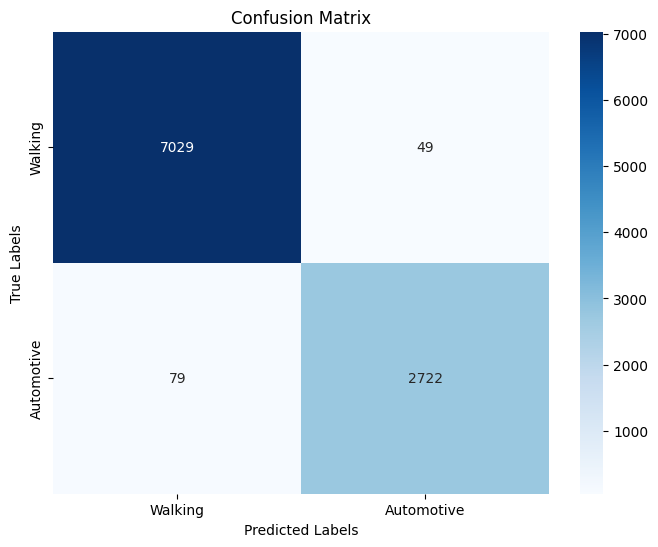

Dimensione del modello: 18.68 KB

Training time: 0.025401592254638672

Testing time: 0.003101825714111328


'\n    from sklearn.model_selection import GridSearchCV\n\n    param_grid = {\n        \'n_estimators\': [3, 5, 10] #, 15, 20, 30, 50, 60, 80, 100, 200, 300],\n        \'max_depth\': [3, 5,  10],\n        \'min_samples_split\': [2, 5, 10],\n    }\n\n    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=\'average_precision\', verbose=3) #Was accuracy\n    grid_search.fit(X_train, y_train)\n\n    print("Best Parameters:", grid_search.best_params_)\n'

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, average_precision_score
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
import os


def random_forest_classifier():
    # Creazione del modello
    rf = RandomForestClassifier(n_estimators=5, max_depth=7, min_samples_split=2)

    # Addestramento del modello
    start_training = time.time()
    rf.fit(X_train, y_train)
    end_training = time.time()
    # Predizione sul set di test
    start_testing = time.time()
    y_pred = rf.predict(X_test)
    end_testing = time.time()
    # Valutazione del modello
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Average precision:", average_precision_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Walking", "Automotive"]) )
    n_params = sum(tree.tree_.node_count for tree in rf.estimators_)
    print(f'Totale parametri del modello Random Forest: {n_params}')

    # Creazione della confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

    # Visualizzazione della confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Walking', 'Automotive'], yticklabels=['Walking', 'Automotive'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Salvataggio del modello su disco
    joblib.dump(rf, 'random_forest_model.pkl')

    # Calcolo della dimensione del file in byte
    model_size_bytes = os.path.getsize('random_forest_model.pkl')

    # Conversione in kilobyte
    model_size_kb = model_size_bytes / 1024

    print(f"Dimensione del modello: {model_size_kb:.2f} KB")

    training_time = end_training - start_training
    testing_time = end_testing - start_testing
    print("\nTraining time:", training_time)
    print("\nTesting time:", testing_time)

    return rf

forest = random_forest_classifier()

    #  Griglia per gli iperparametri della random forest
'''
    from sklearn.model_selection import GridSearchCV

    param_grid = {
        'n_estimators': [3, 5, 10] #, 15, 20, 30, 50, 60, 80, 100, 200, 300],
        'max_depth': [3, 5,  10],
        'min_samples_split': [2, 5, 10],
    }

    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='average_precision', verbose=3) #Was accuracy
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
'''


Qui si fa il test sul sogetto che è stato lasciato fuori dal dataset

In [19]:

# Predizione sul set di test
y_pred = forest.predict(z_sub)

# Valutazione del modello
print("Accuracy:", accuracy_score(z_label, y_pred))
print("Average precision:", average_precision_score(z_label, y_pred))
print("Classification Report:\n", classification_report(z_label, y_pred, target_names=["Walking", "Automotive"]))

Accuracy: 0.9990079365079365
Average precision: 0.8947368421052632
Classification Report:
               precision    recall  f1-score   support

     Walking       1.00      1.00      1.00      9995
  Automotive       0.89      1.00      0.94        85

    accuracy                           1.00     10080
   macro avg       0.95      1.00      0.97     10080
weighted avg       1.00      1.00      1.00     10080



## Qualche grafico per visualizzare cosa impara la random forest

<h3>Precision-Recall AUC </h3>




Questo grafico rappresenta l'area sotto la curva del grafico Precision-Recall. Rappresenta un po' il trade-off tra precision e recall, quindi è un'ottima metrica di valutazione se hai a che fare con dataset sbilanciati (quest'ultimo l'ho generato senza fare resampling, quindi lasciando il dataset molto sbilanciato)

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

" When the dataset is imbalanced, precision-recall curves (PRCs) and the area under those curves may offer a better comparative visualization of model performance. Precision-recall curves are created by plotting precision on the y-axis and recall on the x-axis across all thresholds" - https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

**Hint: guarda come cambia questo grafico diminuendo la max_depth sotto 7, e come invece tutte le altre metriche non sembrano cambiare significativamente nel classification report**

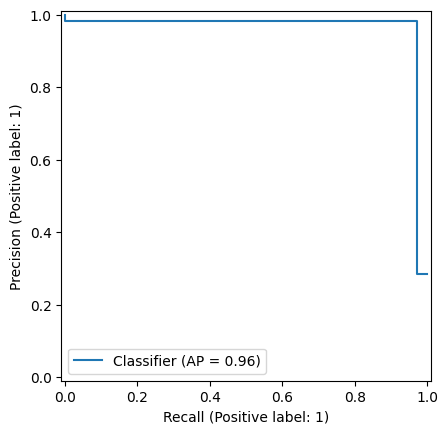

In [20]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_test,forest.predict(X_test))

## Questo grafico è un po' troppo buono

# <h3>Feature importance </h3>



Qui andiamo ad analizzare la feature importance, ovvero quali feature aiutano a "diminuire le impurità" nella costruzione degli alberi. La definizione di impurità dipende dal metodo di "splitting" dell'albero, in questo caso Gini.
Nota che c'è un bias per quelle feature che possono avere più split (ad esempio, una categoria 0/1 sarà per costruzione meno impattante di una feature con 100 possibili valori).
Siccome qui abbiamo a che fare con una foresta, il grafico mostra media e deviazione standard dell'importanza di ogni feature su tutti gli alberi.

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

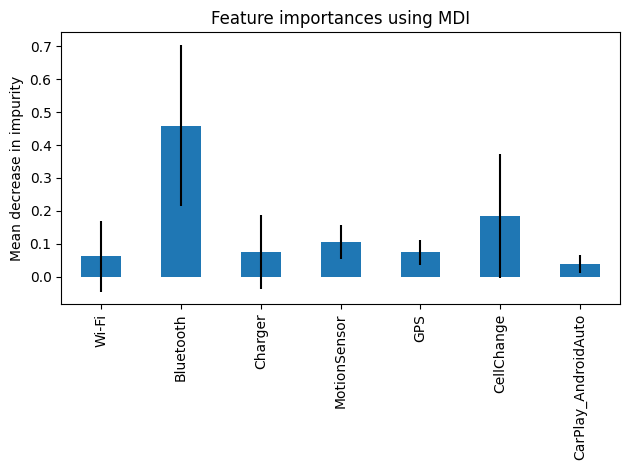

In [21]:
import matplotlib.pyplot as plt


importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)


forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Vediamo i valori unici di ogni label, per capire quanto possono sbilanciare il giudizio sulla feature importance.

In [22]:
data_df = pd.read_csv("/content/csv/out.csv")
data_df.head()
data_df.nunique()

,0
UserID,53
Year,1
Month,1
Day,14
Hour,24
Minute,30
Day of week,7
Wi-Fi,4
Bluetooth,3
Charger,2


<h3> Permutation importance </h3>

Qui si fa una feture importance diversa: presa una feature, e permutata (quindi dato un dataset, i valori di quella feature vengono permutati casualmente), quanto impatta sulla metrica scelta? Ovviamente, trattandosi di una foresta, il grafico mostra media e deviazione standard di questa importanza rispetto a tutti gli alberi.
Quest'altro metodo ha due vantaggi: il primo è che non presenta il bias che ha il precedente grafico, ovvero se una feature può assumere N valori diversi, allora viene considerata più importante; il secondo, si può testare su più **metriche dei dati**, come accuracy, average precision, recall etc..



https://scikit-learn.org/stable/modules/permutation_importance.html

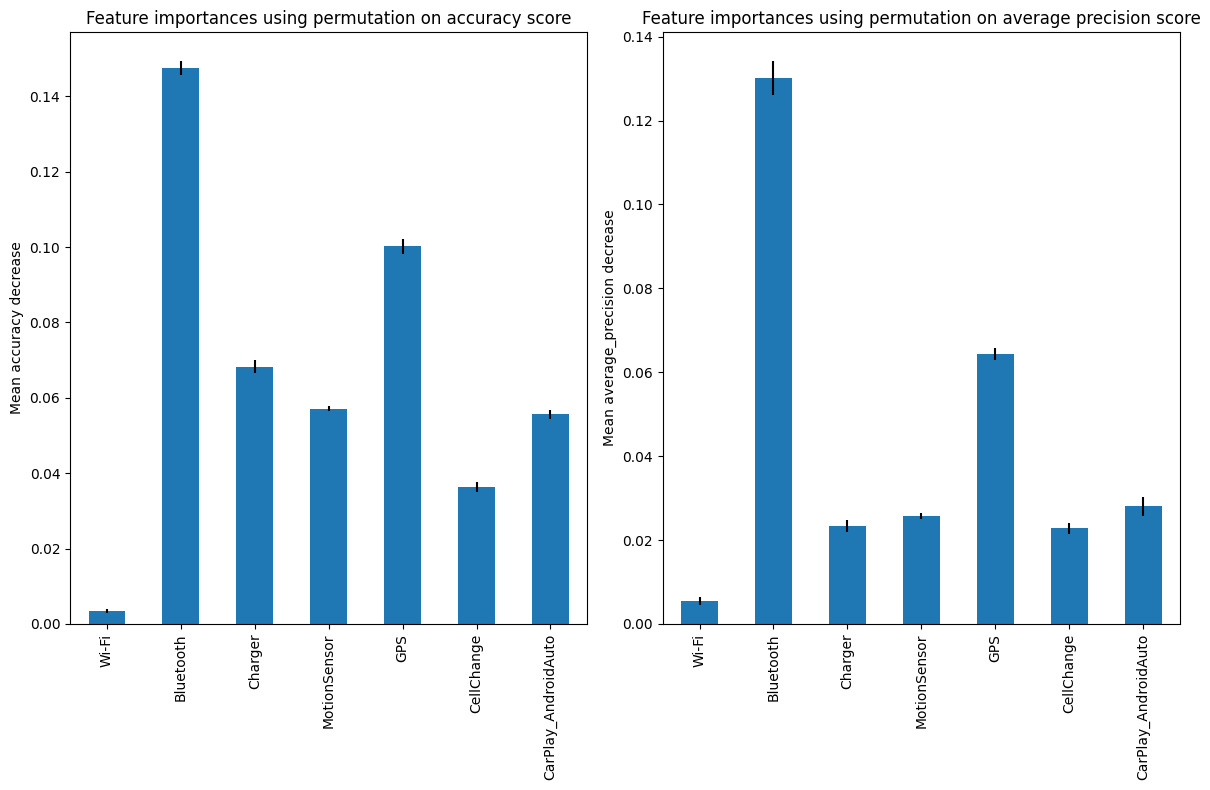

In [23]:
from sklearn.inspection import permutation_importance

scoring_metrics = ["accuracy","average_precision"]
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2, scoring=scoring_metrics
)


forest_importances = pd.Series(result["accuracy"].importances_mean, index=X_train.columns)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
forest_importances.plot.bar(yerr=result["accuracy"].importances_std, ax=ax1)
forest_importances = pd.Series(result["average_precision"].importances_mean, index=X_train.columns)
forest_importances.plot.bar(yerr=result["average_precision"].importances_std, ax=ax2)
ax1.set_title("Feature importances using permutation on accuracy score")
ax1.set_ylabel("Mean accuracy decrease")
ax2.set_title("Feature importances using permutation on average precision score")
ax2.set_ylabel("Mean average_precision decrease")
fig.tight_layout()
plt.show()

L'average precision score rappresenta un po' quello che rappresenta il grafico dell'area sotto la precision-recall curve mostrato prima. Quindi, il secondo grafico mostra quali sono le features che impattano di più sulla capacità del modello di restituire sia risultati accurati, che la maggior parte di essi.

Guardando invece il primo grafico, quello che valuta la sola accuracy, le feature sembrano impattare veramente poco (meno del 3%). Un'ipotesi potrebbe essere che le feature siano significativamente correlate tra di loro, quindi "escludendone" una tramite permutazione, il modello ne usi un'altra altamente correlata con essa, non perdendo di accuracy

<Axes: title={'center': 'Heatmap of linear correlation between features'}>

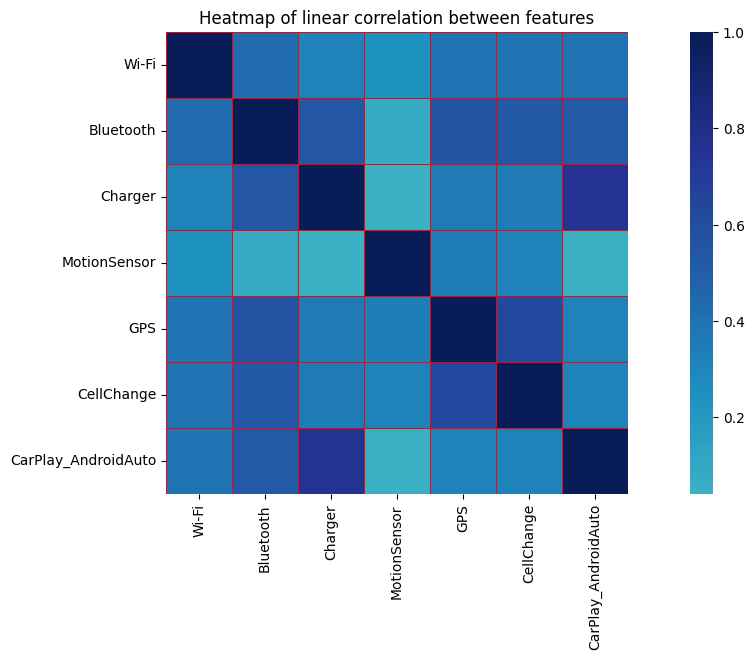

In [24]:
import seaborn as sns   # Plotting library
plt.figure(figsize=(16,6))
plt.title("Heatmap of linear correlation between features")
sns.heatmap(X_train.corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0,linecolor="red",)

Un tentativo potrebbe essere di togliere queste feature correlate tra di loro, lasciandone solo una per gruppo (ad esempio, "Charger" e "Carplay Android" sono molto correlate), e ritrainando il modello, ricalcolando la feature importance, vedere se ora c'è un impatto significativo. Lo lascio a te se vuoi verificare :)

# Decision Tree

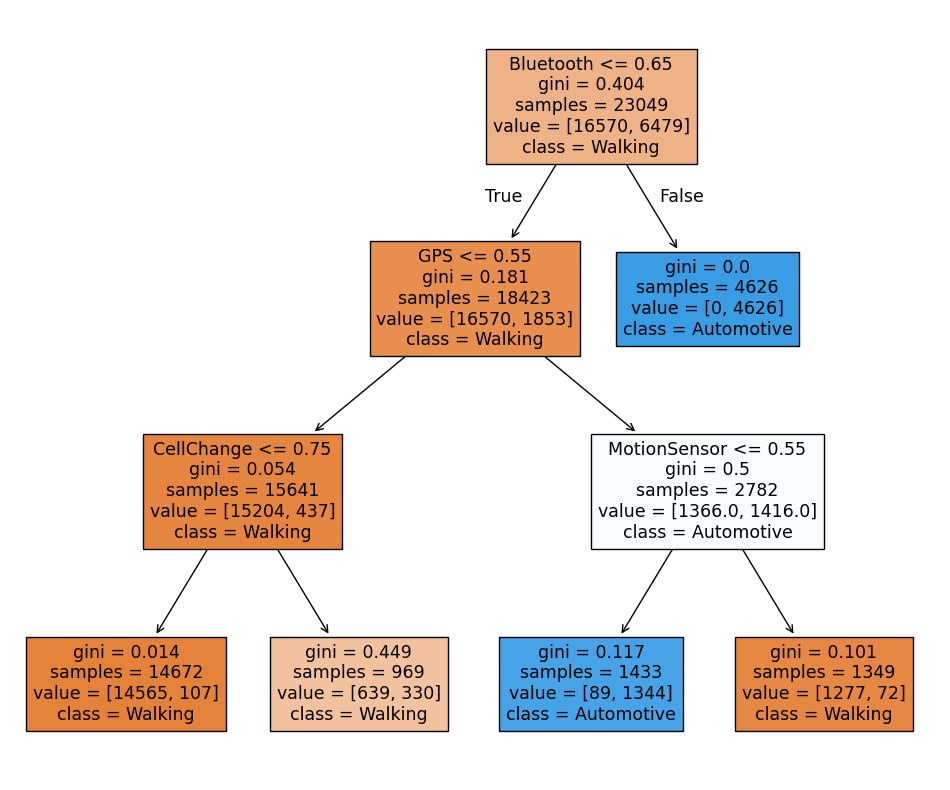

Average precision score:
 0.9332319297498457
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      7078
           1       0.99      0.92      0.95      2801

    accuracy                           0.97      9879
   macro avg       0.98      0.96      0.97      9879
weighted avg       0.98      0.97      0.97      9879

Feature Importances:

Bluetooth  ->  0.7151911622169521
MotionSensor  ->  0.1299870037417416
GPS  ->  0.1306833189151769
CellChange  ->  0.02413851512612942
Number of parameters: 9

Training time: 0.024086952209472656

Testing time: 0.011611461639404297
Dimensione del modello: 2.38 KB


In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
import joblib
import os


def decision_tree_classifier():

    features_names = [ 'Wi-Fi', 'Bluetooth', 'Charger', 'MotionSensor', 'GPS', 'CellChange', 'CarPlay_AndroidAuto']

    class_names = ["Walking", "Automotive"]

    # Potatura con i parametri max_depth e max_leaf_nodes
    tree = DecisionTreeClassifier(max_depth=3, max_leaf_nodes=15)

    start_training = time.time()
    tree.fit(X_train, y_train)
    end_training = time.time()

    plt.figure(figsize=(12, 10))
    plot_tree(tree, feature_names=features_names, class_names=class_names, filled=True)
    plt.show()

    start_testing = time.time()
    y_pred = tree.predict(X_test)
    end_testing = time.time()
    print("Average precision score:\n",average_precision_score(y_test,y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    # Visualizzazione delle feature importances
    print("Feature Importances:\n")
    for i, value in enumerate(tree.feature_importances_):
        if value != 0:
            print(features_names[i], " -> ", value)
    total_params = tree.tree_.node_count
    print(f"Number of parameters: {total_params}")

    training_time = end_training - start_training
    testing_time = end_testing - start_testing
    print("\nTraining time:", training_time)
    print("\nTesting time:", testing_time)

        # Salvataggio del modello su disco
    joblib.dump(tree, 'decision_tree_model.pkl')

    # Calcolo della dimensione del file in byte
    model_size_bytes = os.path.getsize('decision_tree_model.pkl')

    # Conversione in kilobyte
    model_size_kb = model_size_bytes / 1024

    print(f"Dimensione del modello: {model_size_kb:.2f} KB")


decision_tree_classifier()


# Neural Network

Utilizzando il dispositivo: cuda
Epoch [5/60], Loss: 0.6154
Epoch [10/60], Loss: 0.4609
Epoch [15/60], Loss: 0.3799
Epoch [20/60], Loss: 0.3570
Epoch [25/60], Loss: 0.3502
Epoch [30/60], Loss: 0.3452
Epoch [35/60], Loss: 0.3423
Epoch [40/60], Loss: 0.3397
Epoch [45/60], Loss: 0.3373
Epoch [50/60], Loss: 0.3352
Epoch [55/60], Loss: 0.3330
Epoch [60/60], Loss: 0.3308
Accuracy: 0.9844
              precision    recall  f1-score   support

     Walking       0.99      0.99      0.99      7078
  Automotive       0.98      0.97      0.97      2801

    accuracy                           0.98      9879
   macro avg       0.98      0.98      0.98      9879
weighted avg       0.98      0.98      0.98      9879

Number of parameters: 680898


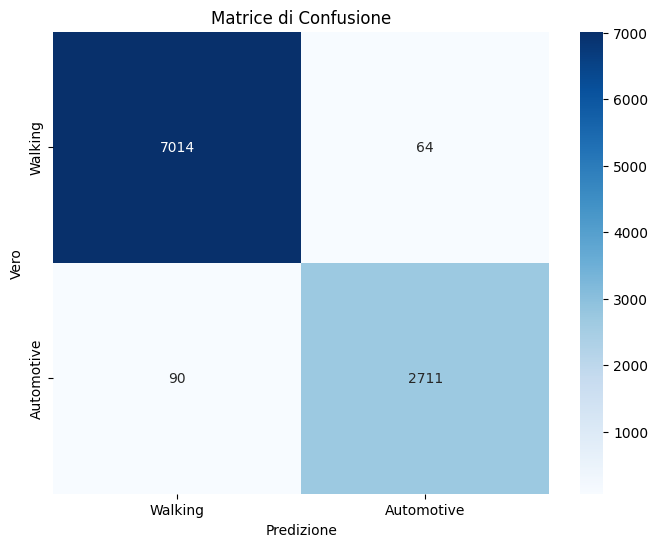

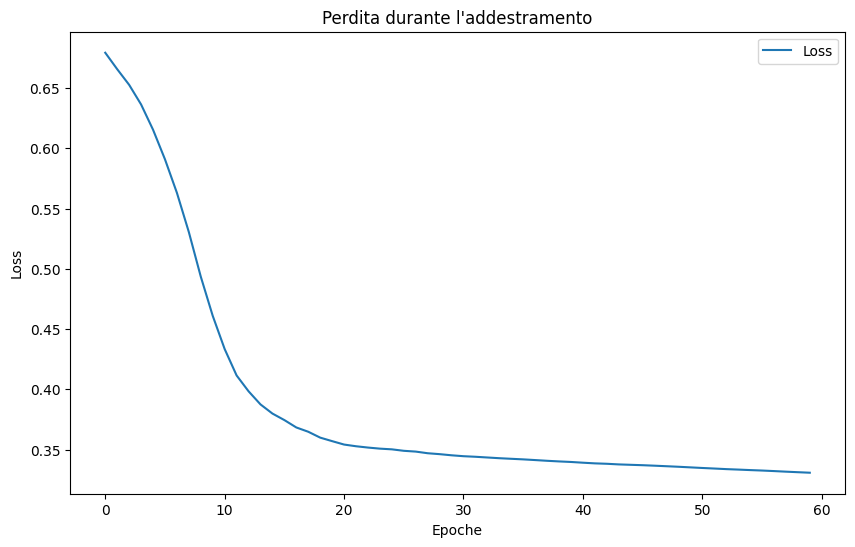


Training time: 1.7486324310302734

Testing time: 0.0004508495330810547
Dimensione del modello: 2663.51 KB


In [36]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import numpy as np
import os

# Verifica della disponibilità della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzando il dispositivo: {device}")

# Conversione dei dati in array NumPy e poi in tensori di PyTorch
X_train_np = np.array(X_train)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train).reshape(-1, 1)
y_test_np = np.array(y_test).reshape(-1, 1)

X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).to(device)

# Definizione della rete neurale
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 64)
        self.fc5 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        #x = self.sigmoid(self.fc5(x))
        x = self.softmax(self.fc5(x))
        return x

# Inizializzazione del modello
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Conversione delle etichette
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long).to(device).view(-1)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.long).to(device).view(-1)

# Lista per salvare la perdita
loss_list = []


# Addestramento del modello
epochs = 60

start_training = time.time()
for epoch in range(epochs):
    model.train()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())  # Salva la perdita in ogni epoca

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
end_training = time.time()
# Valutazione del modello sul set di test
model.eval()
with torch.no_grad():
    start_testing = time.time()
    y_pred = model(X_test_tensor)
    end_testing = time.time()
    y_pred_class = torch.argmax(y_pred, dim=1)
    accuracy = accuracy_score(y_test_tensor.cpu(), y_pred_class.cpu())
    report = classification_report(y_test_tensor.cpu(), y_pred_class.cpu(), target_names=["Walking", "Automotive"], zero_division=0)

print(f'Accuracy: {accuracy:.4f}')
print(report)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

# Creazione della matrice di confusione
conf_matrix = confusion_matrix(y_test_tensor.cpu(), y_pred_class.cpu())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Walking", "Automotive"], yticklabels=["Walking", "Automotive"])
plt.title('Matrice di Confusione')
plt.xlabel('Predizione')
plt.ylabel('Vero')
plt.show()

# Grafico della perdita nel tempo
plt.figure(figsize=(10, 6))
plt.plot(loss_list, label='Loss')
plt.title('Perdita durante l\'addestramento')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.show()

training_time = end_training - start_training
testing_time = end_testing - start_testing
print("\nTraining time:", training_time)
print("\nTesting time:", testing_time)

# Salvataggio il modello su disco
torch.save(model.state_dict(), 'nn_model.pth')

# Calcolo della dimensione del file in byte
model_size_bytes = os.path.getsize('nn_model.pth')

model_size_kb = model_size_bytes / 1024

print(f"Dimensione del modello: {model_size_kb:.2f} KB")

Utilizzando il dispositivo: cuda
Epoch [5/80], Loss: 0.6258
Epoch [10/80], Loss: 0.5284
Epoch [15/80], Loss: 0.3314
Epoch [20/80], Loss: 0.1877
Epoch [25/80], Loss: 0.1334
Epoch [30/80], Loss: 0.1026
Epoch [35/80], Loss: 0.0877
Epoch [40/80], Loss: 0.0746
Epoch [45/80], Loss: 0.0639
Epoch [50/80], Loss: 0.0573
Epoch [55/80], Loss: 0.0536
Epoch [60/80], Loss: 0.0503
Epoch [65/80], Loss: 0.0536
Epoch [70/80], Loss: 0.0518
Epoch [75/80], Loss: 0.0466
Epoch [80/80], Loss: 0.0454
Accuracy: 0.9846
              precision    recall  f1-score   support

     Walking       0.99      0.99      0.99      7078
  Automotive       0.98      0.96      0.97      2801

    accuracy                           0.98      9879
   macro avg       0.98      0.98      0.98      9879
weighted avg       0.98      0.98      0.98      9879

Number of parameters: 338178


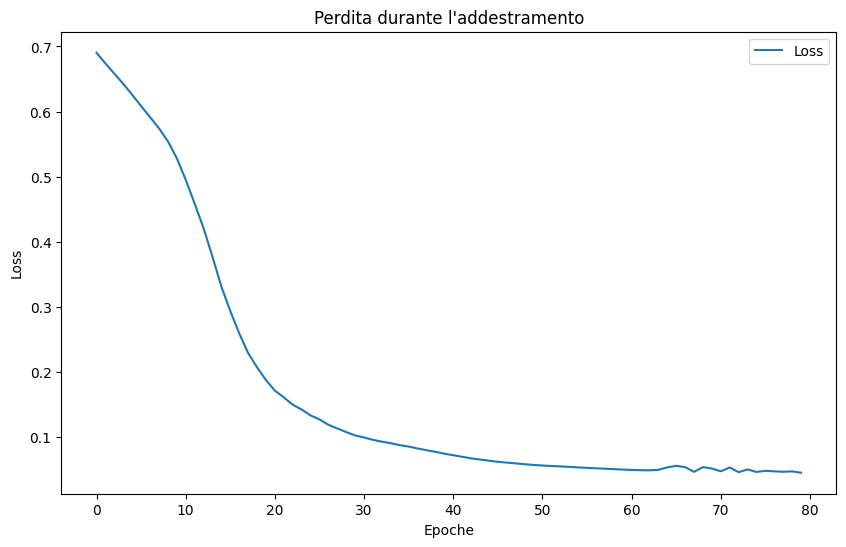

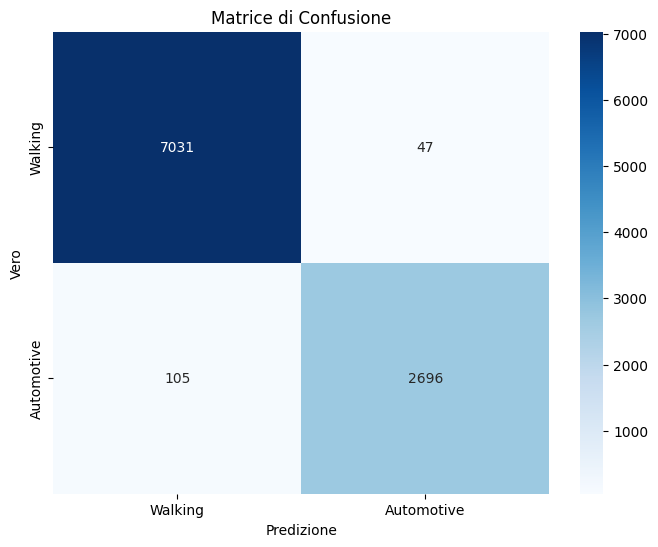


Training time: 5.997040033340454

Testing time: 0.0004508495330810547
Dimensione del modello: 1324.76 KB


In [37]:
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os

# Verifica della disponibilità della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilizzando il dispositivo: {device}")

# Conversione dei dati in array NumPy e poi in tensori di PyTorch
X_train_np = np.array(X_train, dtype=np.float32)
X_test_np = np.array(X_test, dtype=np.float32)
y_train_np = np.array(y_train, dtype=np.int64)
y_test_np = np.array(y_test, dtype=np.int64)

# Reshape per CNN 1D: (batch_size, num_channels, sequence_length)
X_train_np = X_train_np[:, np.newaxis, :]  # Aggiungi una dimensione per i canali
X_test_np = X_test_np[:, np.newaxis, :]

X_train_tensor = torch.tensor(X_train_np).to(device)
X_test_tensor = torch.tensor(X_test_np).to(device)
y_train_tensor = torch.tensor(y_train_np).to(device)
y_test_tensor = torch.tensor(y_test_np).to(device)

loss_list = []
# Definizione della CNN 1D
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.fc1 = nn.Linear(256 * (X_train_np.shape[2] // 4), 512)  # 4 è il numero di riduzioni di pooling
        self.fc2 = nn.Linear(512, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = self.relu(self.conv3(x))

        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN1D().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Addestramento del modello
epochs = 80
start_training = time.time()
for epoch in range(epochs):
    model.train()

    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
end_training = time.time()
# Valutazione del modello sul set di test
model.eval()
with torch.no_grad():
    start_test = time.time()
    y_pred = model(X_test_tensor)
    end_test = time.time()
    y_pred_class = torch.argmax(y_pred, dim=1)
    accuracy = accuracy_score(y_test_tensor.cpu(), y_pred_class.cpu())
    report = classification_report(y_test_tensor.cpu(), y_pred_class.cpu(), target_names=["Walking", "Automotive"], zero_division=0)

print(f'Accuracy: {accuracy:.4f}')
print(report)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

# Grafico della perdita nel tempo
plt.figure(figsize=(10, 6))
plt.plot(loss_list, label='Loss')
plt.title('Perdita durante l\'addestramento')
plt.xlabel('Epoche')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Creazione della matrice di confusione
conf_matrix = confusion_matrix(y_test_tensor.cpu(), y_pred_class.cpu())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Walking", "Automotive"], yticklabels=["Walking", "Automotive"])
plt.title('Matrice di Confusione')
plt.xlabel('Predizione')
plt.ylabel('Vero')
plt.show()

training_time = end_training - start_training
testing_time = end_testing - start_testing
print("\nTraining time:", training_time)
print("\nTesting time:", testing_time)

# Salvataggio il modello su disco
torch.save(model.state_dict(), 'nn_model.pth')

# Calcolo della dimensione del file in byte
model_size_bytes = os.path.getsize('nn_model.pth')

model_size_kb = model_size_bytes / 1024

print(f"Dimensione del modello: {model_size_kb:.2f} KB")
